In [1]:
import torch
from torch import nn
import random,numpy
import numpy as np
from copy import deepcopy
from game import Game, Move, RandomPlayer, MyPlayer,translate_number_to_position_direction,translate_number_to_position,TrainedPlayer
import torch.nn.init as init

## Training the agent

In [2]:
## Constants definition

# These parameter have been obtained by running a genetic algorithm over individuals representing the network hyper parameters
# Based on the fact that the agent could start as first/second, we might have different hyperparameters for the network

num_iterations = 300
num_matches = 6
max_dim_replay_buff = 589
time_to_update = 27
gamma = 0.280
batch_size=409

device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [3]:
class ReplayBuffer:    
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size        
        self.buffer = []
        self.position = 0
        
    def add_experience(self, experience):        
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(experience)        
        else:
            self.buffer[self.position] = experience        
            self.position = (self.position + 1) % self.buffer_size
            
    def sample_batch(self, batch_size):
        batch_indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        batch = [self.buffer[i] for i in batch_indices]
        return batch

In [4]:
from game import Player
from tqdm import tqdm


def training(agent_to_train: 'Player', opponent: 'Player', starts_first: bool):
    loss_tot = []
    taboo_set = set()

    replay_buff = ReplayBuffer(max_dim_replay_buff) # replay buffer, from which we sample for BATCH learning
    # inizializza i modelli -> passali per parametro
    torch.set_grad_enabled(True)
    
    for step in tqdm(range(num_iterations), desc="Training Iterations"):  
        # we fill the replay buffer with experiences made with matches
        #player1.step=step
        for match in range(num_matches):
            # lo uso solo in inferenza
            # gioca una intera partita qui dentro e per ogni mossa, metti l'experience dentro il ReplayBuffer
            # ...
            # ... qui descrivere come viene effettivamente usata la rete neurale (magari impacchettarla in qualche funzione)
            winner = -1
            g = Game()
            #g.current_player_idx = match%2
            g.current_player_idx = int(starts_first) # Se è True viene settato ad 1, ed all'interno del ciclo (con l'aggiornamento del g.current_player_idx) l'agent_to _train parte per primo

            #player1 = MyPlayer()
            #player2 = RandomPlayer()
            players = [agent_to_train, opponent]   # CAMBIA IL NOME DEL PLAYER1 A AGENT_TO_TRAIN

            go = False # serve a calcolare lo stato successivo per il calcolo del target

            while winner < 0:
                    g.current_player_idx += 1
                    g.current_player_idx %= len(players)
                    prev_state=deepcopy(g)
                    from_pos, slide = players[g.current_player_idx].make_move(g)
                    g._Game__move(from_pos, slide, g.current_player_idx)
                    
                    if g.current_player_idx==0: 
                        ##l'azione è il valore del q-value quindi un numero? o la posizione in questo caso
                        ##in quel caso replay_row=(prev_state.get_board,GeneratorNet((prev_state.get_board),g.get_board,reward)
                        reward=g.compute_reward(from_pos, slide)
                        go = True
                        #io qua dentro x ogni row voglio i 44 output della mia rete
                        
                        #replay_row=(prev_state.get_flat_board(),player1.last_action_number, deepcopy(g), reward)

                        # faccio fare una mossa all'avversario e poi faccio il max action sul nuovo stato che mi ritorna
                        
                    elif go and g.current_player_idx==1: 
                        if (tuple(prev_state.get_flat_board()), agent_to_train.last_action_number, tuple(deepcopy(g).get_flat_board())) not in taboo_set :
                            replay_row=(prev_state.get_flat_board(), agent_to_train.last_action_number, deepcopy(g), reward, reward==1)
                            taboo_set.add((tuple(prev_state.get_flat_board()),agent_to_train.last_action_number, tuple(deepcopy(g).get_flat_board())))
                            #eliminato last_action da replay row?? Non dovrebbe servire
                            replay_buff.add_experience(replay_row)


                    if g.check_winner() != -1:
                        break
            
            # replay_buffer.push(...) per ogni transizione di stato osservata ()
            # restituisci il risultato sotto forma di tupla (st, a, st+1, r) - (State, action, next_state, reward)
            
        # Now we sample a batch of data from the ReplayBuffer in order to train the Agent
        batch_to_train = replay_buff.sample_batch(batch_size)
      
        #divide the batch
        state_batch, action_num, next_state_batch, reward, done = zip(*batch_to_train) 

        #forward the Generator
        q_values = agent_to_train.GeneratorNet(torch.tensor(state_batch, dtype=torch.float32)).to(agent_to_train.device)
        q_values_target = torch.zeros(batch_size, 44).to(agent_to_train.device)


        #update q_values target by using Bellman Equation  
        for i in range(batch_size): 
            if done[i] == False:
                q_values_target[i, action_num[i]] = reward[i] + gamma * torch.tensor(agent_to_train.compute_target(next_state_batch[i])).to(agent_to_train.device).item()
            else:
               q_values_target[i, action_num[i]] = reward[i] 
          
        agent_to_train.optimizer.zero_grad()
        loss_curr=agent_to_train.criterion(q_values,q_values_target).to(agent_to_train.device)
        loss_curr.backward()
    
        agent_to_train.optimizer.step()

        loss_tot.append(loss_curr)
      
        if (step % time_to_update) == 0:
            # update the parameter of the TargetNet
            agent_to_train.copy_params_TargetNet()
            
       
        #printa come varia 
   
    return agent_to_train.GeneratorNet.state_dict(), loss_tot
            
      

In [5]:
#MAGARI EMBEDDA TUTTE LE VARIABILI PER IL TRAINING DA QUALCHE PARTE E INSERISCI DENTRO Training(...) (con arg parser)

agent_to_train = MyPlayer()
opponent = RandomPlayer()
#TrainedGeneratorNet_first = TrainedPlayer()
TrainedGeneratorNet_second = TrainedPlayer()

#trained_model_params_first, loss_tot_first = training(agent_train_first, opponent, True) # this model is trained to start first
trained_model_params_second, loss_tot_second = training(agent_to_train, opponent, False) # this model is trained to start second

# TRAINED NETWORK to use in INFERENCE PHASE
#TrainedGeneratorNet_first.GeneratorNet.load_state_dict(trained_model_params_first) 
TrainedGeneratorNet_second.GeneratorNet.load_state_dict(trained_model_params_second)

Training Iterations:   0%|          | 0/300 [00:00<?, ?it/s]C:\Users\chito\AppData\Local\Temp\ipykernel_4040\1850521848.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  q_values = agent_to_train.GeneratorNet(torch.tensor(state_batch, dtype=torch.float32)).to(agent_to_train.device)
Training Iterations: 100%|██████████| 300/300 [02:02<00:00,  2.45it/s]


<All keys matched successfully>

## Loss function visualization

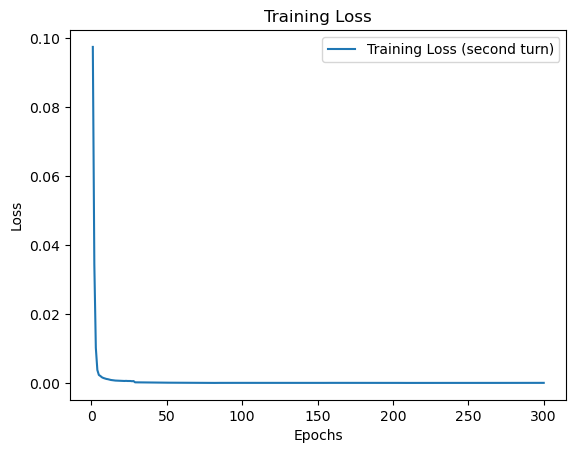

In [6]:
from matplotlib import pyplot as plt

#vals_first = [el.detach().numpy() for el in loss_tot_first]
vals_second = [el.detach().numpy() for el in loss_tot_second]

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, len(loss_tot_second) + 1)

# Plot and label the training and validation loss values
#plt.plot(epochs, vals_first, label='Training Loss (first turn)')
plt.plot(epochs, vals_second, label='Training Loss (second turn)')


# Add title and axes labels
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend()
plt.show()

In [7]:
#torch.save(TrainedGeneratorNet_first.GeneratorNet.state_dict(), './trained_models/try_first.pth')
torch.save(TrainedGeneratorNet_second.GeneratorNet.state_dict(), './trained_models/try_second.pth')

In [12]:
from game import Game, RandomPlayer, MyPlayer, TrainedPlayer, TrainedPlayer_Complete
from tqdm import tqdm
import torch

TrainedGeneratorNet = TrainedPlayer()
TrainedGeneratorNet.GeneratorNet.load_state_dict(torch.load('./trained_models/try_second.pth'))

wins = 0
losts = 0
draws = 0
num_match_test = 100

for step in tqdm(range(num_match_test), desc="Game"):
    player=RandomPlayer()
    g=Game()
    #g.current_player_idx = step%2
    #g.current_player_idx = 1
    winner=g.play(TrainedGeneratorNet, player)
    if winner==0:
        wins+=1
       
    if winner==1:
        losts+=1
        
    if winner ==-1:
        draws+=1

print(f"Accuracy: {(wins/num_match_test)*100}")

Game: 100%|██████████| 100/100 [00:01<00:00, 82.04it/s]

Accuracy: 67.0


In [9]:
#torch.save(TrainedGeneratorNet_first.GeneratorNet.state_dict(), './trained_models/try_first.pth')
torch.save(TrainedGeneratorNet_second.GeneratorNet.state_dict(), './trained_models/try_second.pth')